In [1]:
import copy
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch import nn
from sklearn.metrics import accuracy_score

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from cassava.utils import *
from cassava.transforms import get_train_transforms, get_test_transforms

In [4]:
from pl_bolts.models.self_supervised import MocoV2

In [5]:
from pytorch_lightning import Trainer
from argparse import Namespace

# Prepare data

In [6]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-09 22:31:47,898 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [7]:
train_labels = context.catalog.load('train_labels')

2020-12-09 22:31:47,919 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [8]:
parameters = context.catalog.load('parameters')

2020-12-09 22:31:47,948 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [9]:
parameters

{'seed': 42,
 'validation_size': 0.15,
 'gpus': -1,
 'data_loader_workers': 6,
 'batch_size': 10,
 'max_epochs': 100,
 'max_steps': 0,
 'auto_lr_find': 0,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'early_stop_patience': 4,
 'reduce_lr_on_pleteau_patience': 2,
 'save_top_k_checkpoints': 1,
 'checkpoints_dir': 'data/06_models/checkpoints',
 'cv_splits': 3,
 'cv_models_dir': 'data/06_models/cv_folds'}

In [10]:
res = context.pipelines['train'].nodes[0].run({'train_labels': train_labels, 'parameters': parameters})
train_indices = np.array(res['train_indices'])
val_indices = np.array(res['val_indices'])

2020-12-09 22:31:47,960 - kedro.pipeline.node - INFO - Running node: split: split_data([parameters,train_labels]) -> [train_indices,val_indices]


In [11]:
train_indices.shape, val_indices.shape

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((18187,), (3210,))

In [12]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [13]:
raw_transforms = A.Compose([
        A.ToFloat(max_value=1.0),
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
])

def get_train_transforms():
    return A.Compose([
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=1),
        A.ToFloat(max_value=1.0),
        A.RandomResizedCrop(256, 256, scale=(0.3, 0.9)),
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


def get_test_transforms():
    return A.Compose([
        A.ToFloat(max_value=1.0),
        A.CenterCrop(400, 400),
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [14]:
train_transform, val_transform = get_train_transforms(), get_test_transforms()

train_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=train_indices),
                                      transform=train_transform)

val_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=val_indices),
                                transform=val_transform)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=parameters['batch_size'],
                                                num_workers=parameters['data_loader_workers'],
                                                shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val_dataset, num_workers=parameters['data_loader_workers'], batch_size=parameters['batch_size'])

In [15]:
raw_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=raw_transforms)
augmented_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_train_transforms())
test_aug_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_test_transforms())

3


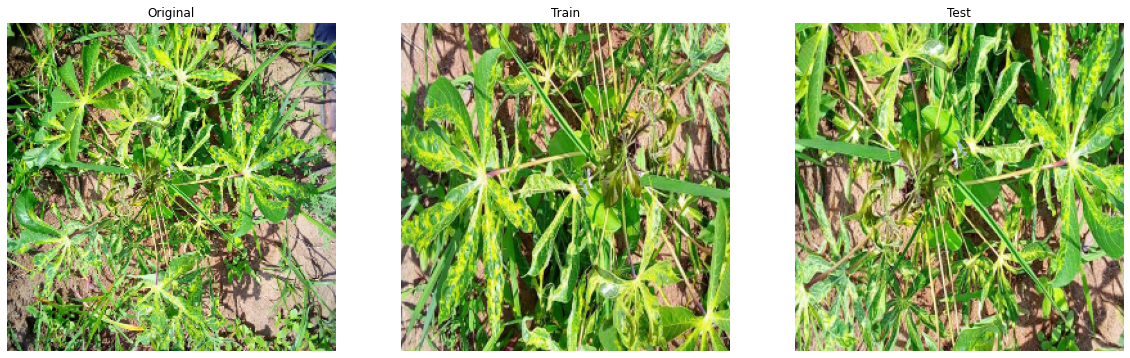

In [16]:
idx = np.random.choice(range(len(train_images_torch)))
raw_image, label = raw_dataset[idx]
aug_image, _ = augmented_dataset[idx]
test_aug_image, _ = test_aug_dataset[idx]

print(label)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plot_image(unnorm(raw_image))
plt.title('Original')
plt.subplot(1, 3, 2)
plot_image(unnorm(aug_image))
plt.title('Train')
plt.subplot(1, 3, 3)
plot_image(unnorm(test_aug_image))
plt.title('Test')
plt.show()

In [17]:
raw_image.shape, aug_image.shape, test_aug_image.shape

(torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]))

# Define model

In [18]:
#!pip install pytorch-lightning-bolts

# Train

In [19]:
!pip install byol-pytorch

You should consider upgrading via the '/home/boris/Documents/kaggle cassava/venv/bin/python3 -m pip install --upgrade pip' command.


In [30]:
import pytorch_lightning as pl
import torch
from byol_pytorch import BYOL
from torchvision import models

class BYOLModel(pl.LightningModule):
    def __init__(self, hparams = None):
        super().__init__()
        self.hparams = hparams or Namespace()

        self.learner = BYOL(
            models.resnet18(pretrained=True),
            image_size = 256,
            hidden_layer = 'avgpool',
        )


    def forward(self, x):
        return self.learner(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.learner.parameters(), lr=3e-4)

        return {
            'optimizer': optimizer,
        }

    def training_step(self, batch, batch_idx):
        images, labels = batch
        loss = self.learner(images)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def on_before_zero_grad(self, opt):
        self.learner.update_moving_average()

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        loss = self.learner(images)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

In [31]:
parameters['auto_lr_find'] = True
# parameters['lr'] = 0.1
hparams = Namespace(**parameters)

In [32]:
model = BYOLModel(hparams)

In [33]:

trainer = Trainer.from_argparse_args(
    hparams,
    reload_dataloaders_every_epoch = True,
    gradient_clip_val=1,
    accumulate_grad_batches = 1,
    terminate_on_nan = True,
)

GPU available: True, used: True


2020-12-09 22:32:50,844 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-09 22:32:50,846 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-09 22:32:50,848 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type | Params
---------------------------------
0 | learner | BYOL | 31.8 M


2020-12-09 22:32:51,060 - lightning - INFO - 
  | Name    | Type | Params
---------------------------------
0 | learner | BYOL | 31.8 M


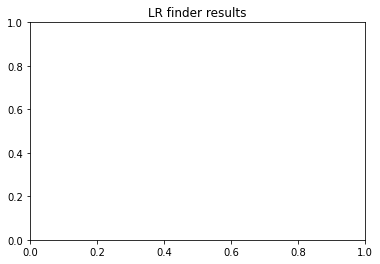

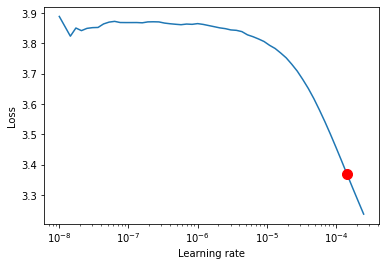

0.0001445439770745928

In [34]:
lr_finder = trainer.tuner.lr_find(model,
                                  train_dataloader=train_data_loader,
                                  val_dataloaders=[val_data_loader])
plt.figure()
plt.title('LR finder results')
lr_finder.plot(suggest=True)
plt.show()
new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr
new_lr

In [35]:
trainer.fit(model, train_data_loader, val_data_loader)


  | Name    | Type | Params
---------------------------------
0 | learner | BYOL | 31.8 M


2020-12-09 22:33:06,414 - lightning - INFO - 
  | Name    | Type | Params
---------------------------------
0 | learner | BYOL | 31.8 M


1

In [ ]:
model = model.eval()

In [ ]:
model.model(raw_image.unsqueeze(0).to('cpu')).shape